In [1]:
! pip install split-folders

import os
import numpy as np
import pandas as pd
import random
import cv2
import copy
import shutil
import matplotlib.pyplot as plt
import splitfolders
%matplotlib inline
import keras
# Deep learning libraries
import torch
import torch.nn as nn
from torch import optim, cuda
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, sampler,Dataset
from torchvision import models
from torchvision import transforms,datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from google.colab import files
from PIL import Image, ImageOps
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

from keras.models import Model,Sequential,load_model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

# Download Datasets

In [2]:
# Mount google drive to use uploaded dataset from kaggle
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!pip install -q kaggle

# Upload the kaggle.json file
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Make directory named kaggle and copy kaggle.json file there.
!chmod 600 ~/.kaggle/kaggle.json

# Make directory named kaggle and copy kaggle.json file there.
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Saving kaggle.json to kaggle.json
100% 778M/778M [00:43<00:00, 20.2MB/s]
100% 778M/778M [00:43<00:00, 18.6MB/s]


In [4]:
# Unzip the downloaded archive
!unzip -u covid19-radiography-database.zip -d /content/drive/MyDrive/covid19/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/covid19/COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: /content/drive/MyDrive/covid19/COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: /content/drive/MyDrive/covid19/COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: /content/drive/MyDrive/covid19/COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: /content/drive/MyDrive/covid19/COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: /content/drive/MyDrive/covid19/COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: /content/drive/MyDrive/covid19/COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: /content/drive/MyDrive/covid19/COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: /content/drive/MyDrive/covid19/COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: 

In [53]:
path_dataset = "/content/drive/MyDrive/covid19/COVID-19_Radiography_Dataset"
path_working = "/working"
path_train = "/output/train"
path_val = "/output/val"
path_test = "/output/test"
path_normal = path_working + '/normal'
path_covid = path_working + '/covid'
path_lung_opacity = path_working +"/lung_opacity"
path_viral_pneumonia = path_working +"/viral_pneumonia"

LR = 0.0001
EPOCHS = 7
BATCH_SIZE = 32
IMG_SIZE = 224

In [7]:
try:
  shutil.rmtree(path_working)
  os.mkdir(path_working)
except:
    pass

shutil.copytree(path_dataset + '/Normal/images', path_normal)
shutil.copytree(path_dataset + '/COVID/images', path_covid)
shutil.copytree(path_dataset + '/Lung_Opacity/images', path_lung_opacity)
shutil.copytree(path_dataset + '/Viral Pneumonia/images', path_viral_pneumonia)

NUM_CLASSES = len(os.listdir(path_working))

In [8]:
try:
  shutil.rmtree('/output')
  os.mkdir('/output')
except:
    pass

# 80% training 10% validation 10% testing
# can use train_test_split from scikit as well
splitfolders.ratio(path_working, output='/output', seed=1234, ratio=(0.8, 0.1, 0.1), group_prefix=None)

Copying files: 21165 files [00:03, 5404.42 files/s]


## Chest X-ray Bar Chart

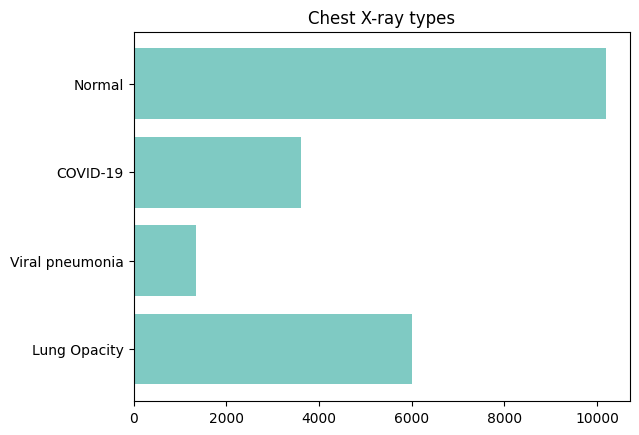

In [9]:
len_normal = len(os.listdir(path_normal))
len_covid = len(os.listdir(path_covid))
len_viral_pneumonia = len(os.listdir(path_viral_pneumonia))
len_lung_opacity = len(os.listdir(path_lung_opacity))

objects = ('Lung Opacity', 'Viral pneumonia', 'COVID-19', 'Normal')
y_pos = np.arange(len(objects))
performance = [len_lung_opacity, len_viral_pneumonia, len_covid, len_normal]

plt.barh(y_pos,performance, align='center', alpha=0.5, color='#009688')
plt.yticks(y_pos, objects)
plt.title('Chest X-ray types')

plt.show()

## Sample Preview of X-Rays

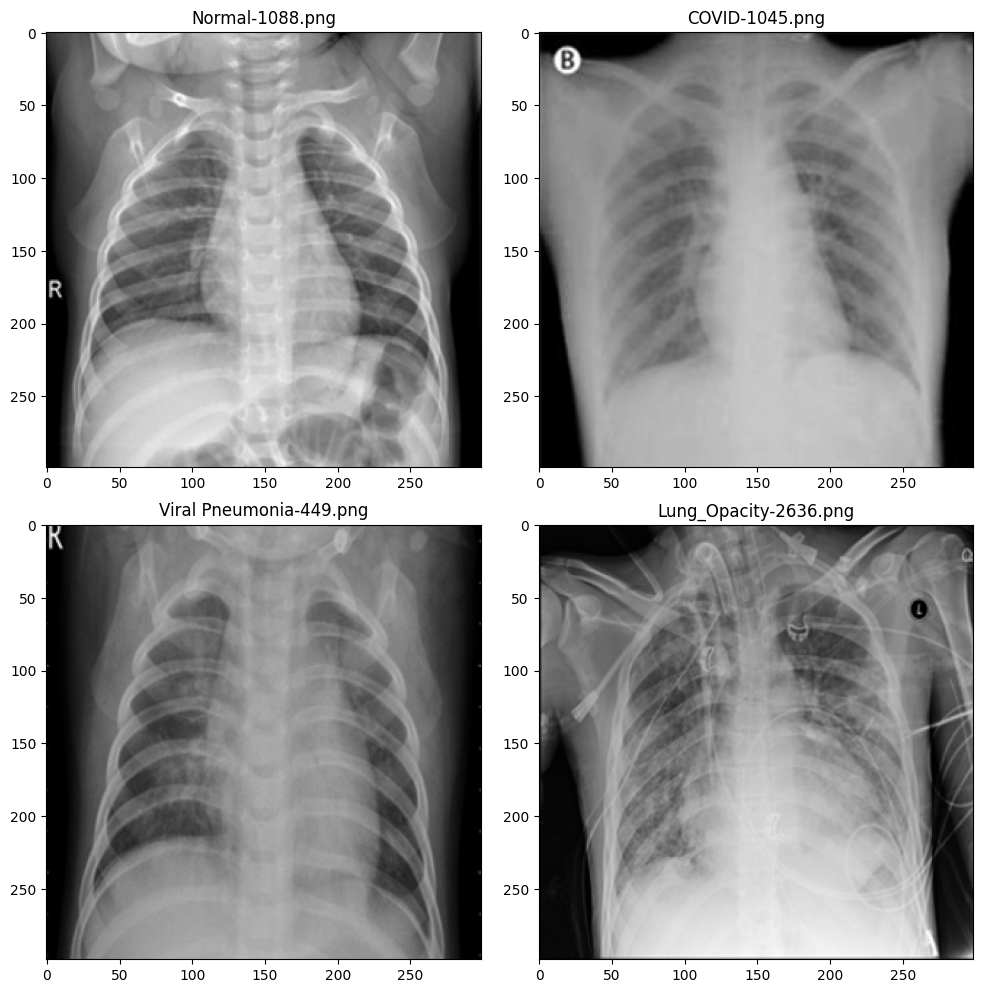

In [10]:
def gridify(imgs, skip=False):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax = ax.ravel()
    plt.tight_layout()

    for i in range(0,4):
      ax[i].imshow(plt.imread(imgs[i][0]) if not skip else imgs[i][0], cmap='gray')
      ax[i].set_title(imgs[i][1])

img1 = path_normal + "/Normal-1088.png", "Normal-1088.png"
img2 = path_covid + "/COVID-1045.png", "COVID-1045.png"
img3 = path_viral_pneumonia + "/Viral Pneumonia-449.png", "Viral Pneumonia-449.png"
img4 = path_lung_opacity + "/Lung_Opacity-2636.png", "Lung_Opacity-2636.png"

gridify([img1, img2, img3, img4])

# Pre-processing Images

In [11]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

# Import the images from the train dataset.
train_set = train_datagen.flow_from_directory(
    directory = path_train,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

print(train_set.class_indices)

Found 16930 images belonging to 4 classes.
{'covid': 0, 'lung_opacity': 1, 'normal': 2, 'viral_pneumonia': 3}


In [12]:
test_datagen = ImageDataGenerator(rescale = 1./255)

# Import the images from the test dataset.
test_set = test_datagen.flow_from_directory(
    directory = path_test,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

print(test_set.class_indices)

Found 2120 images belonging to 4 classes.
{'covid': 0, 'lung_opacity': 1, 'normal': 2, 'viral_pneumonia': 3}


In [13]:
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_directory(
    directory = path_val,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)
print(validation_set.class_indices)

Found 2115 images belonging to 4 classes.
{'covid': 0, 'lung_opacity': 1, 'normal': 2, 'viral_pneumonia': 3}


# Initializing VGG16 Model

In [14]:
#Transfer learning with VGG16
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers:
  layer.trainable = False
output = Flatten()(base_model.output)
output = Dense(NUM_CLASSES, activation='softmax')(output)
covid_model = Model(base_model.input, outputs=output)

covid_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

# Training

In [57]:
covid_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = covid_model.fit(
  train_set,
  validation_data=test_set,
  epochs=EPOCHS,
  steps_per_epoch=len(train_set),
  validation_steps=len(test_set)
)

print(history.history.keys())

covid_model.save('/content/drive/MyDrive/covid19/covid_model_final.h5')

Epoch 1/7
530/530 [==============================] - 257s 484ms/step - loss: 0.4094 - accuracy: 0.8537 - val_loss: 0.3419 - val_accuracy: 0.8840
Epoch 2/7
530/530 [==============================] - 249s 470ms/step - loss: 0.3693 - accuracy: 0.8683 - val_loss: 0.3314 - val_accuracy: 0.8811
Epoch 3/7
530/530 [==============================] - 251s 474ms/step - loss: 0.3456 - accuracy: 0.8752 - val_loss: 0.2999 - val_accuracy: 0.8920
Epoch 4/7
530/530 [==============================] - 256s 483ms/step - loss: 0.3317 - accuracy: 0.8818 - val_loss: 0.3165 - val_accuracy: 0.8929
Epoch 5/7
530/530 [==============================] - 244s 461ms/step - loss: 0.3366 - accuracy: 0.8815 - val_loss: 0.3933 - val_accuracy: 0.8712
Epoch 6/7
530/530 [==============================] - 247s 465ms/step - loss: 0.3296 - accuracy: 0.8826 - val_loss: 0.3642 - val_accuracy: 0.8651
Epoch 7/7
530/530 [==============================] - 248s 467ms/step - loss: 0.3037 - accuracy: 0.8927 - val_loss: 0.3362 - val_ac

# Evaluation

In [58]:
validation_steps = 200

loss0,accuracy0 = covid_model.evaluate(validation_set, steps = validation_steps)

print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

 66/200 [========>.....................] - ETA: 18s - loss: 0.3548 - accuracy: 0.8897

200/200 [==============================] - 10s 47ms/step - loss: 0.3547 - accuracy: 0.8894
loss: 0.35
accuracy: 0.89


In [27]:
x_test = np.concatenate([test_set.next()[0] for i in range(test_set.__len__())])
y_test = np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])

67/67 [==============================] - 9s 139ms/step
              precision    recall  f1-score   support

           0       0.17      0.16      0.16       363
           1       0.28      0.24      0.26       602
           2       0.49      0.55      0.52      1020
           3       0.05      0.04      0.05       135

    accuracy                           0.36      2120
   macro avg       0.25      0.25      0.25      2120
weighted avg       0.35      0.36      0.35      2120

ACC: 0.0958
Sensitivity: 0.3826
Specificity: 0.6033


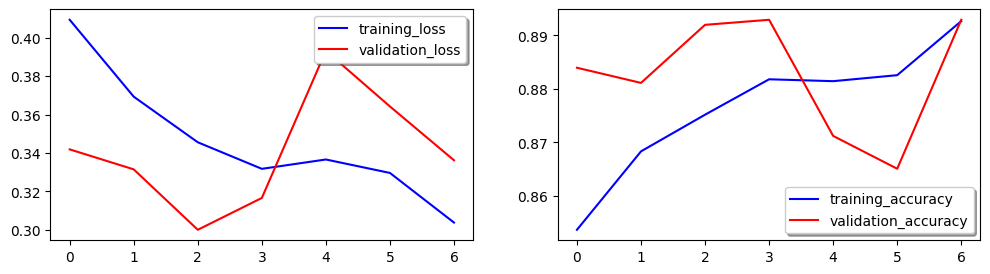

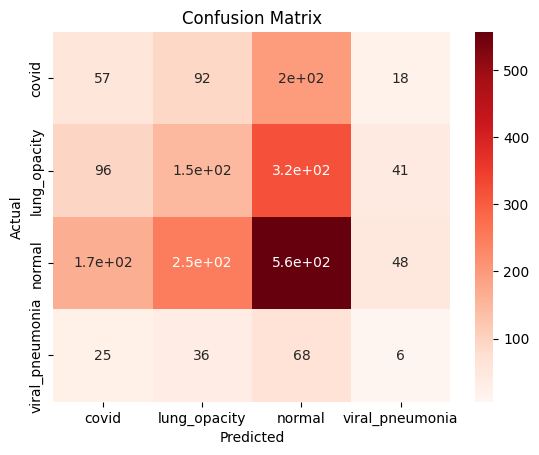

In [59]:
def display_history(history_):
    fig, ax = plt.subplots(1,2, figsize=(12, 3))
    ax[0].plot(history_.history['loss'], color='b', label="training_loss")
    ax[0].plot(history_.history['val_loss'], color='r', label="validation_loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history_.history['accuracy'], color='b', label="training_accuracy")
    ax[1].plot(history_.history['val_accuracy'], color='r',label="validation_accuracy")
    legend = ax[1].legend(loc='best', shadow=True)


def plot_metrices(model_):
    plt.figure()
    ax = plt.subplot()
    ax.set_title('Confusion Matrix')

    pred = model_.predict(x_test, batch_size = BATCH_SIZE)
    pred = np.argmax(pred, axis = 1)
    cm = confusion_matrix(y_test.argmax(axis = 1), pred)
    classes=test_set.class_indices
    sns.heatmap(cm, annot = True, xticklabels = classes, yticklabels = classes, cmap = 'Reds')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show

    print(classification_report(y_test.argmax(axis = 1), pred))
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

    print("ACC: {:.4f}".format(acc))
    print("Sensitivity: {:.4f}".format(sensitivity))
    print("Specificity: {:.4f}".format(specificity))

display_history(history)
plot_metrices(covid_model)

# Predict

In [70]:
def model_predict(i,n):
  img = image.image_utils.load_img(path_dataset + "/" + i + "/images/" + i + "-" + n + ".png", target_size = (224, 224))
  x = image.image_utils.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  x_processed = preprocess_input(x)
  result = covid_model.predict(x_processed)

  ind = np.argmax(result)
  mx = np.max(result)

  if(ind == 0):
      result="covid"
  else:
      result="not_covid"

  plt.figure()
  plt.imshow(img)
  plt.title('Actual : {} --> Predicted  : {}'.format(i + '-' + n + '.png', result))

1/1 [==============================] - 0s 24ms/step


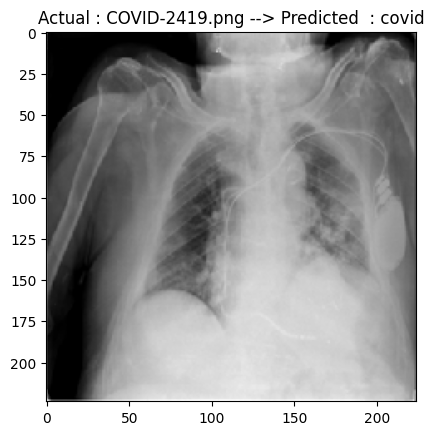

In [71]:
pred = model_predict('COVID', '2419')

1/1 [==============================] - 0s 21ms/step


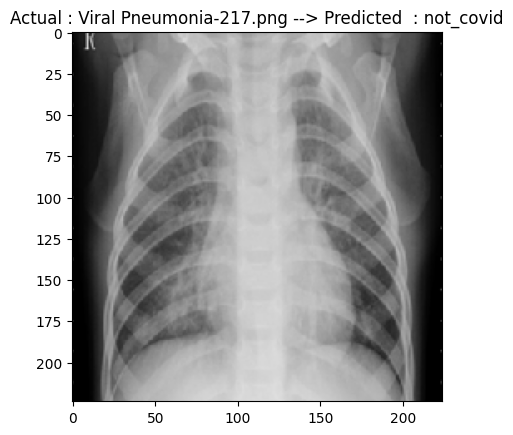

In [72]:
pred = model_predict('Viral Pneumonia', '217')

1/1 [==============================] - 0s 21ms/step


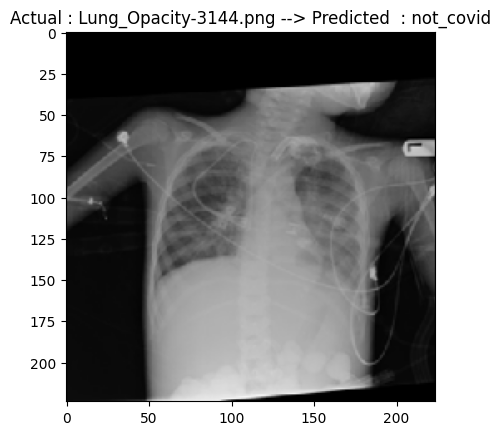

In [73]:
pred = model_predict('Lung_Opacity', '3144')